In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
DEBUG = True
USE_SIMPLE = False

In [3]:
from pathlib import Path
import random
import sys

try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

import ignite
from ignite import engine as ie
from ignite.metrics import Loss
from ignite.handlers import EarlyStopping, Timer, ModelCheckpoint
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from loop.torch_helpers.modules import FineTunedModel, AdaptiveConcatPool2d, Flatten, classname
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from basedir import use_simple, get_num_landmarks, get_train_folder, get_valid_folder
from dataset import LandmarksFromFiles
from layers import fc, conv
from metrics import rmse_loss
from transform import MatrixAugmentation, AdjustGamma, CropResizeFace, ToXY
from utils import split, IMAGENET_STATS

SEED = 1
DEVICE = torch.device('cuda:1')
use_simple(USE_SIMPLE)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
if DEBUG:
    num_workers = 0
else:
    import os
    from multiprocessing import cpu_count
    num_workers = cpu_count()
    os.environ['PYTHONBREAKPOINT'] = '0'

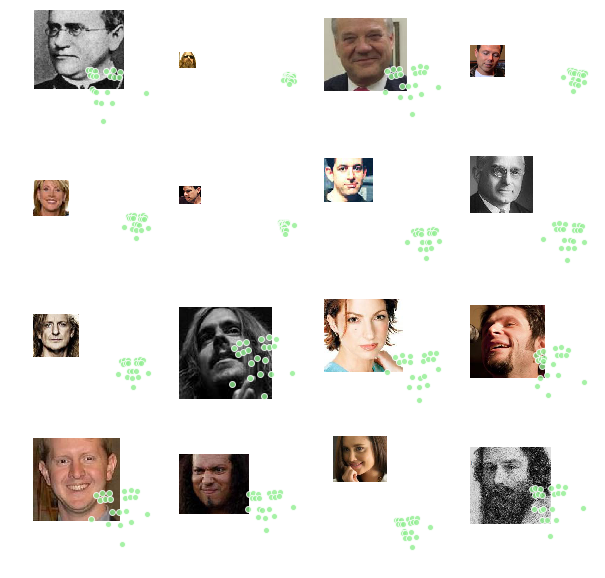

In [5]:
LandmarksFromFiles(get_train_folder()).show_random_grid()

In [8]:
def to_np(t):
    return t.cpu().detach().numpy()

In [9]:
def compute_featurewise_mean_std(dataset, batch_size=512, num_workers=0):
    n = 1
    mean, var = None, None
    for i in range(len(dataset)):
        x, _ = dataset[i]
        x = torch.tensor(x.astype(np.float32))
        x.div_(255)
        if var is None and mean is None:
            mean, var = x, torch.ones_like(x)
        else:
            var.mul_(n - 2).div_(n - 1)
            var.add_(x.sub(mean).pow(2).div(n))
            mean.mul_(n - 1).add_(x).div_(n)
        n += 1
    var.sqrt_().add_(1e-7)
    return mean, var

In [10]:
stats = compute_featurewise_mean_std(LandmarksFromFiles(get_train_folder()))

RuntimeError: The size of tensor a (65) must match the size of tensor b (71) at non-singleton dimension 1

In [ ]:
PER_CHANNEL_STATS = [(x.mean().item(),) * 3 for x in stats]
PER_CHANNEL_STATS

In [ ]:
train_trf = [
    MatrixAugmentation([
        {'name': 'rotation', 'angle': 10},
        {'name': 'mirror'},
        {'name': 'perspective', 'percentage': (0.075, 0.012)}]),
    CropResizeFace(pad=0.15),
    AdjustGamma(min_gamma=0.8)]

valid_trf = [CropResizeFace(pad=0.15)]
converter = ToXY(PER_CHANNEL_STATS, expand_channels=True)
train_dir, valid_dir = get_train_folder(), get_valid_folder()

if valid_dir is not None:
    # datasets with data separeted between folders
    trn_ds, val_ds = [
        LandmarksFromFiles(folder=f, transforms=t, to_tensors=converter)
        for (f, t) in zip((train_dir, valid_dir), (train_trf, valid_trf))
    ]
else:
    # UMDFaces dataset
    meta = pd.read_csv(META)
    meta.columns = meta.columns.str.lower()
    items = [create_dataset_item(record, DATA) for _, record in meta.iterrows()]
    trn_idx, val_idx = train_test_split(np.arange(len(items)), test_size=0.1, random_state=SEED)
    train = np.array(items)[trn_idx].tolist()
    valid = np.array(items)[val_idx].tolist()
    trn_ds, val_ds = [
        FaceLandmarks(items=items, transforms=t, to_tensors=converter)
        for (items, t) in zip((train, valid), (train_trf, valid_trf))
    ]

In [ ]:
# trn_ds = LandmarksFromFiles(
#     folder=get_train_folder(), 
#     transforms=[
#         MatrixAugmentation([
#             {'name': 'rotation', 'angle': 10},
#             {'name': 'mirror'},
#             {'name': 'perspective', 'percentage': (0.075, 0.012)}]),
#         CropResizeFace(pad=0.15),
#         AdjustGamma(min_gamma=0.8)], 
#     to_tensors=ToXY(PER_CHANNEL_STATS, expand_channels=True))

# val_ds = LandmarksFromFiles(
#     folder=get_valid_folder(),
#     transforms=[CropResizeFace(pad=0.15)],
#     to_tensors=ToXY(PER_CHANNEL_STATS, expand_channels=True))

In [11]:
trn_ds.show_random_grid(6, transformed=True)

NameError: name 'trn_ds' is not defined

In [ ]:
def create_data_loaders(train_data, valid_data, bs=512, num_workers=0):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader

In [ ]:
class LandmarksRegressor(nn.Module):
    def __init__(self, layers, top=None):
        super().__init__()
        if top is not None:
            layers.append(top)
        self.model = nn.ModuleList(layers)
        self.model.apply(self.init)
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
        
    def init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)
        elif classname(m).startswith('BatchNorm'):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 1e-3)

In [ ]:
def conv_model(ni, no, pool=False, res=True):
    pool = (2, 2) if pool else None
    stride = 1 if pool is not None else 2
    layers  = conv( ni,  16, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 16,  32, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 32,  64, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv( 64, 128, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += conv(128, 256, 3, stride, bn=True, activ='leaky_relu', pool=pool)
    layers += [AdaptiveConcatPool2d(1), Flatten()]
    layers += fc(512, 500, dropout=0.50, activ='relu')
    layers += fc(500, 500, dropout=0.50, activ='relu')
    layers += fc(500, 500, dropout=0.25, activ='relu')
    layers += fc(500, no)
    return layers

In [ ]:
# building model
reg = LandmarksRegressor(conv_model(3, get_num_landmarks(), pool=True), top=nn.Tanh())

In [ ]:
# configuring optimizer and training loop
opt = optim.Adam(reg.parameters())
loss = rmse_loss
trainer = ie.create_supervised_trainer(reg, opt, loss, device=DEVICE)
evaluator = ie.create_supervised_evaluator(reg, device=DEVICE, metrics={'rmse': Loss(loss)})

def score_function(engine):
    val_loss = engine.state.metrics['rmse']
    return -val_loss

# preparing data loaders and training loop
epochs = 500
log_interval = 1
lrs = []
trn_dl, val_dl = create_data_loaders(trn_ds, val_ds, bs=300, num_workers=num_workers)
sched = CosineAnnealingScheduler(opt, 'lr', 1e-1, 1e-4, cycle_size=len(trn_dl), cycle_mult=2)
early_stopping = EarlyStopping(patience=250, score_function=score_function, trainer=trainer)
checkpoint = ModelCheckpoint('/tmp/models/', 'zero',
                             score_name='rmse_val_loss',
                             require_empty=False, 
                             score_function=score_function,
                             create_dir=True)

# binding events
trainer.add_event_handler(ie.Events.ITERATION_COMPLETED, sched)
evaluator.add_event_handler(ie.Events.COMPLETED, checkpoint, {'model': reg})
evaluator.add_event_handler(ie.Events.COMPLETED, early_stopping)

@trainer.on(ie.Events.ITERATION_COMPLETED)
def save_lr(engine):
    lrs.append(opt.param_groups[0]['lr'])

@trainer.on(ie.Events.EPOCH_COMPLETED)
def log_training_results(engine):
    epoch = engine.state.epoch
    evaluator.run(trn_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    if epoch % log_interval == 0:
        print('Train - Epoch: {} Avg loss {:.4f}'.format(epoch, avg_loss))
    
@trainer.on(ie.Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    epoch = engine.state.epoch
    evaluator.run(val_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    if epoch % log_interval == 0:
        print('Valid - Epoch: {} Avg loss {:.4f}'.format(epoch, avg_loss))

In [ ]:
reg

In [ ]:
trainer.run(trn_dl, max_epochs=epochs)

In [ ]:
test_img, test_pts = val_ds[0]
reg.eval()
pred = reg(test_img[None].to(DEVICE))
np_img, np_pts = val_ds.to_tensors.inverse(test_img, pred)
plt.imshow(np_img)
plt.scatter(*split(np_pts))